# Data and Code for "Fault-network geometry influences earthquake frictional behaviour"

This Jupyter notebook demonstrates the analyses from the paper, 'Fault-Network Geometry Influences Earthquake Frictional Behavior,' authored by J. Lee, V. C. Tsai, G. Hirth, A. Chatterjee, and D. T. Trugman.

In [1]:
import faultMetric as fM
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygmt
import rioxarray as rio
import seaborn as sns
from scipy.interpolate import griddata, RBFInterpolator
from shapely.geometry import LineString
from shapely.geometry import mapping
from shapely import ops

import warnings
warnings.filterwarnings('ignore')

# Set UTM projection.
longitude = -122
utm_zone = int(math.floor((longitude + 180) / 6) + 1)
utm_crs = f'+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

The surface creep rate dataset from Johnson et al. (2022) is sampled at uniform spacing (10 km) along the faults.
Undefined uncertainties in the dataset were replaced with the mean standard deviations of the entire dataset. Weighted mean and standard deviations are calculated for all data measurements within circle area of 5 km radius.

San Andreas
Imperial
Berryessa
Bartlett Springs
Garlock
Calaveras
Concord
San Jacinto
Superstition Hills
Greenville
Green Valley
Hayward
Hunting Creek
Maacama
Rodgers Creek
San Gregorio
Total processed samples: 208


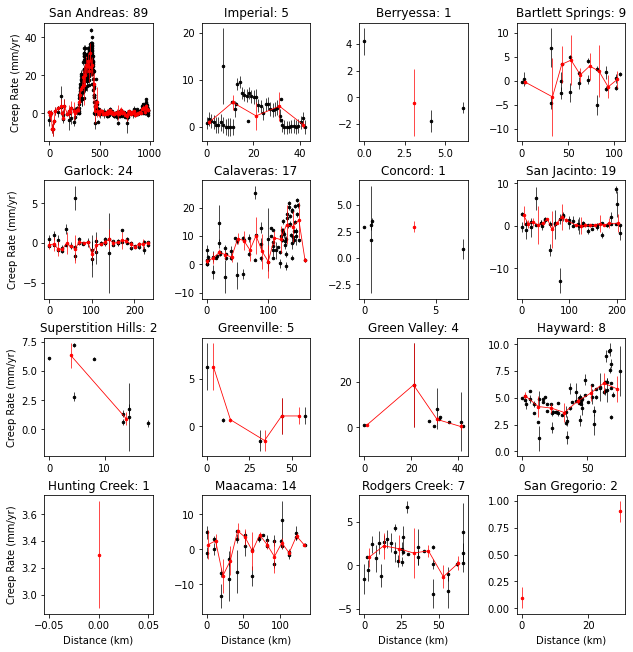

In [2]:
# Compiled creep data from Johnson et al. (2022)
creep = pd.read_pickle('./creep_data.pkl').to_crs(utm_crs) 
sampled_creep = gpd.GeoDataFrame()

def filter_points(points, fault):
    """Exclude points not on the main fault strand (used only for line interpolation)."""
    if fault in ['San Andreas', 'Imperial', 'Calaveras']:
        return points[points['Location Description'].isnull()]
    elif fault == 'Rodgers Creek':
        return points.drop([594, 285, 153])
    return points

def calculate_creep_rates(points, faultline):
    """Calculate and return estimated creep rates and their standard deviations.
    
    Args:
        points (GeoDataFrame): Location of creep measurements
        faultline (LineString): Geometric line representation along the fault.
        
    Returns:
        tuple: Three lists containing the resampled points, new creep rates, and their standard deviations.
    """
    
    # Initialize lists to store the results
    resample = []
    new_creep = []
    std_creep = []
    
    # Calculate interpolation distances along the faultline at regular intervals
    interval = 10000
    start = faultline.length % interval / 2

    # Estimate the mean and standard deviation for every interpolated point
    for distance in np.arange(start, faultline.length, interval):
        interpolated_point = faultline.interpolate(distance)
        buffer_zone = interpolated_point.buffer(5000)
        # Select datasets within the area of 5km radius
        points_within_buffer = points[points.within(buffer_zone)]
        
        # Only process if there are datasets within the area
        if not points_within_buffer.empty:
            resample.append(interpolated_point)
            
            # Calculate the weighted average if there is enough data
            if len(points_within_buffer) > 1:
                weighted_average_cr = np.average(
                    points_within_buffer.CR, 
                    weights=1 / points_within_buffer.sig**2
                )
                variance_cr = np.cov(
                    points_within_buffer.CR, 
                    aweights=1 / points_within_buffer.sig**2
                )
                std_dev_cr = np.sqrt(variance_cr)
            else:
                # Use the direct values if only one point
                weighted_average_cr = points_within_buffer.CR.values[0]
                std_dev_cr = points_within_buffer.sig.values[0]
            
            new_creep.append(weighted_average_cr)
            std_creep.append(std_dev_cr)

    return resample, new_creep, std_creep



# Setup the plot layout
fig, ax = plt.subplots(4, 4, figsize=(9, 9))
fig.tight_layout(pad=1.8)
axes = ax.flatten()

i = 0  # Initialize plot index

# Iterate for all fault systems
for fault in creep.Fault.unique():
    print(fault)
    points = creep[creep.Fault == fault].sort_values('lon')
    linepoints = filter_points(points, fault)
    
    if len(points) > 2:
        faultline = LineString(linepoints.geometry.values)
        resample, new_creep, std_creep = calculate_creep_rates(points, faultline)
        distance_raw = np.array([faultline.project(p) for p in points.geometry.values])
        distance_sampled = np.array([faultline.project(p) for p in resample])
        
        axes[i].errorbar(distance_raw / 1000, points.CR.values, yerr=points.sig.values, fmt='o', color='black', ms=2.5, elinewidth=0.7)
        axes[i].plot(distance_sampled / 1000, new_creep, color='red', zorder=10, linewidth=0.8)
        axes[i].errorbar(distance_sampled / 1000, new_creep, yerr=std_creep, color='red', zorder=10, fmt='o', ms=2.5, elinewidth=0.7)

    # Handling the cases where there are only 1 and 2 data measurements
    else:
        resample = points.geometry
        new_creep = points.CR
        std_creep = points.sig

        if len(points)==2: # San Gregorio
            faultline = LineString(linepoints.geometry.values)
            distance_sampled = np.array([faultline.project(p) for p in resample])
            axes[i].errorbar(distance_sampled / 1000, new_creep, yerr=std_creep, color='red', zorder=10, fmt='o', ms=2.5, elinewidth=0.7)
        
        if len(points)==1: # Hunting Creek
            axes[i].errorbar([0],new_creep,yerr=std_creep,color='red',fmt='o',ms=2.5,elinewidth=0.7)
 
    # Compile all estimated creep data
    creep_onfault = gpd.GeoDataFrame({'geometry': resample, 'meanCR': new_creep, 'fault': fault, 'stdCR': std_creep})
    sampled_creep = pd.concat([sampled_creep, creep_onfault], ignore_index=True)
    
    if i > 11:
        axes[i].set_xlabel('Distance (km)')
    if i % 4 == 0:
        axes[i].set_ylabel('Creep Rate (mm/yr)')
    axes[i].set_title(f"{fault}: {len(new_creep)}")
    i += 1

print(f"Total processed samples: {len(sampled_creep)}")

Fault complexity metrics at sampled creep locations are calculated using the USGS Quaternary Fault Database.
More details can be found in the code faultMetric.py. Duplicate faults have been removed.

In [3]:
# Surface Fault Traces from the USGS Quaternary Fault Database
faults = pd.read_pickle('./fault_data.pkl')

# Transform CRS to UTM coordinates
faults_utm = faults.to_crs(utm_crs)

zone = sampled_creep.copy()
zone.geometry = sampled_creep.buffer(15*1000) # 15 km radius area
zone = zone.set_crs(utm_crs)
zone = fM.calculate_RmRd(zone,faults_utm)

Codes for plotting the data on a map (Figure 1), using PyGMT.

grdimage [WARNING]: The x-coordinates and range attribute are in conflict; must rely on coordinates only
grdimage [WARNING]: The y-coordinates and range attribute are in conflict; must rely on coordinates only


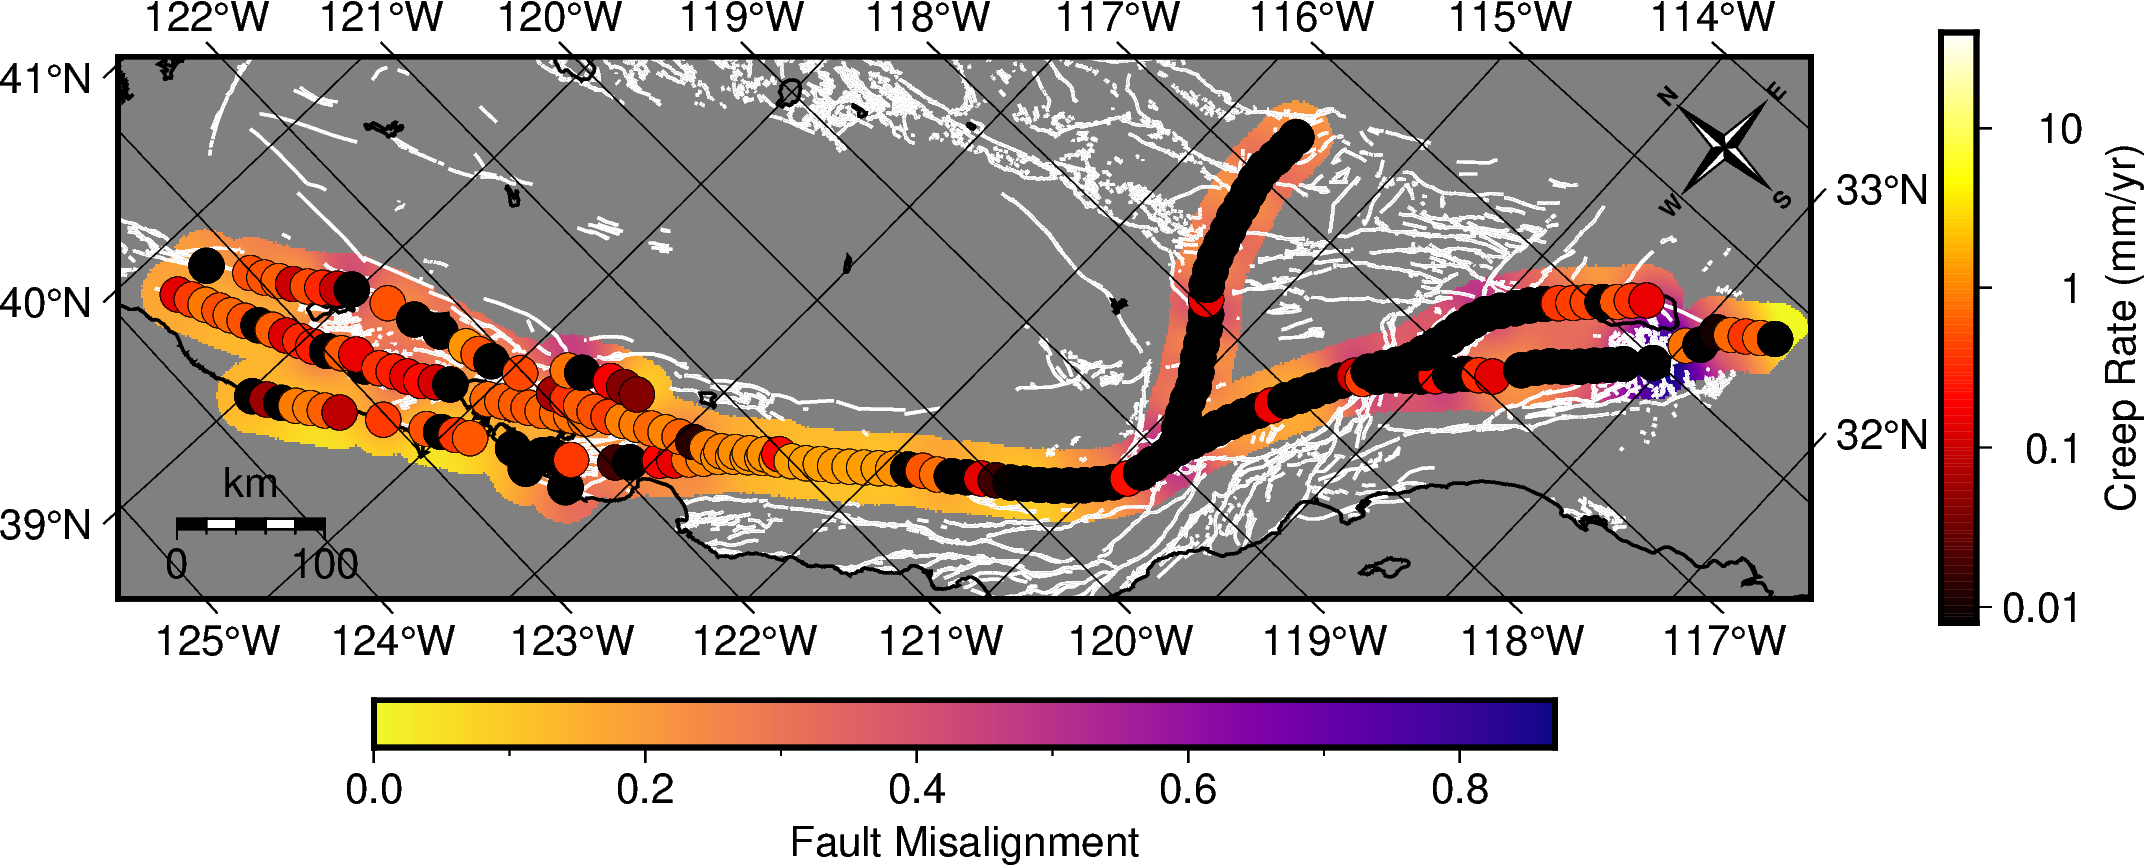

In [4]:
# Initialize the figure
fig = pygmt.Figure()
fig.shift_origin(yshift="4c")
minX, minY, maxX, maxY = [-126, 32.5, -115, 41]

# Set up the basemap
fig.basemap(region="-125.5/38.6/-113.6/33.6+r", projection="oa-120/36/-45/1:8000000", frame="nswe")

# Create a GeoDataFrame for the region
region = gpd.GeoDataFrame(index=["region"], geometry=[ops.unary_union(zone.buffer(10000))])
region = region.set_crs(utm_crs)

# Convert to WGS84
region = region.to_crs('epsg:4326')
zone = zone.to_crs('epsg:4326')

# Calculate centroid coordinates for zone
zone['lon'] = zone.geometry.centroid.x
zone['lat'] = zone.geometry.centroid.y
zone = zone.sort_values('lon', ignore_index=True)

# Create a grid for interpolation
xi = np.arange(minX, maxX, 0.01)
yi = np.arange(minY, maxY, 0.01)
xi, yi = np.meshgrid(xi, yi)
xi, yi = xi.flatten(), yi.flatten()

# Interpolate Rm values using RBF
f = RBFInterpolator(np.array([zone.lon, zone.lat]).T, zone.Rm, smoothing=0.01)
grid_Rm = pygmt.xyz2grd(x=xi, y=yi, z=f(np.array([xi, yi]).T), spacing='0.01', region=[minX, maxX, minY, maxY])
grid_Rm = pygmt.grdclip(grid_Rm, below=[0, 0])

# Clip the grid to the region
grid_Rm = grid_Rm.rio.write_crs(region.crs)
inside = grid_Rm.rio.clip(region.geometry.apply(mapping), region.crs, drop=True, invert=False)
inside.to_netcdf('./tempGrid')

# Create and apply colormaps. Plot Rm and creep rate values
cmap1 = pygmt.makecpt(cmap="plasma", series=[0, 0.87], reverse=True)
fig.grdimage(grid='./tempGrid', cmap=cmap1)
fig.plot(data=faults, color='black', pen='0.025c,white', connection='rr')
fig.coast(resolution="high", area_thresh=10, shorelines='0.025c')
cmap2 = pygmt.makecpt(cmap="hot", series=[-2.1, 1.6, 0.01], log=True, output='./temp.cpt')
fig.plot(x=zone.lon, y=zone.lat, style="c0.3c", color=np.log10(np.abs(zone.meanCR)), cmap='./temp.cpt', pen='0.05p,black')

# Add map scale, rose, and colorbars
size = "10p"
with pygmt.config(FONT_ANNOT_PRIMARY=size, FONT_ANNOT_SECONDARY=size, FONT_HEADING=size, FONT_LABEL=size, FONT_LOGO=size, FONT_SUBTITLE=size, FONT_TAG=size, FONT_TITLE=size, FONT_ANNOT=size):
    fig.basemap(map_scale='jBL+w100k+o0.5c/0.5c+f+l"km"', rose="JTR+o-1.5c/-1.5c+w1c+l+f", frame=["WSNE", "a1f1g1"], region="-125.5/38.6/-113.6/33.6+r", projection="oa-120/36/-45/1:8000000")
    fig.colorbar(frame='a10f10+l"Creep Rate (mm/yr)"', cmap='./temp.cpt', position="JMR+o1.1c/0c+w5c/0.3c", Q=True)
    fig.colorbar(frame='af+l"Fault Misalignment"', cmap=cmap1, position="JCB+w10c/0.4c+h")

fig.show()

Codes for plotting the data as violin plots (Figure 2). 2.5% outliers at both ends are excluded, showing 95% of the distributions.

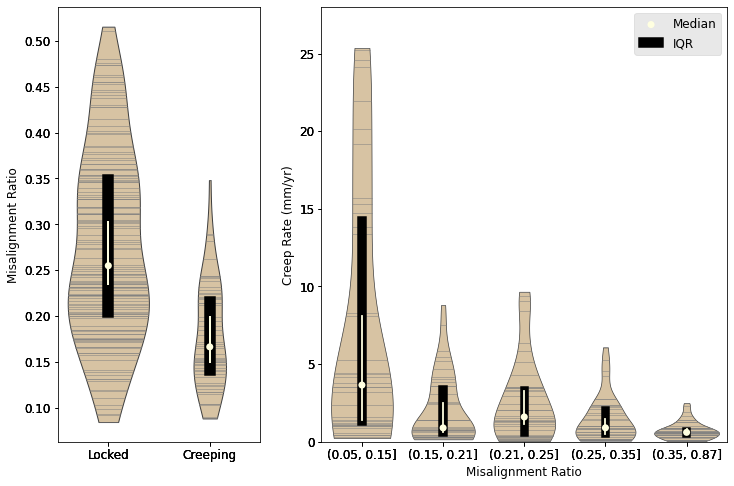

In [5]:
# Update plot parameters
plt.rcParams.update({'font.size': 12, 'font.weight': 'normal'})

# Figure 2a.
zone['meanCR'] = np.abs(zone['meanCR'])
zone["catCR"] = (np.abs(zone['meanCR']) > 3).astype(int)
zone['plot'] = False

# Filter outliers
for cat in zone['catCR'].unique():
    cut1 = zone[zone['catCR'] == cat]['Rm'].quantile(0.975)
    cut2 = zone[zone['catCR'] == cat]['Rm'].quantile(0.025)
    zone.loc[(zone['catCR'] == cat) & (zone['Rm'] < cut1) & (zone['Rm'] > cut2), 'plot'] = True

zone_filtered = zone[zone['plot']].sort_values('catCR').reset_index(drop=True)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 2]})
ax[0].set_axis_off()
ax[1].set_axis_off()

# Violin, box, and point plots for the filtered data. The plots are overlaid on different axes.
ax1 = fig.add_subplot(121)
sns.violinplot(data=zone_filtered, x="catCR", y="Rm", scale='count', linewidth=1, inner='stick', ax=ax1, cut=0)

ax2 = fig.add_subplot(121, frameon=False, sharex=ax1, sharey=ax1)
sns.boxplot(data=zone_filtered, x="catCR", y="Rm", showcaps=False, showfliers=False, width=0.1, medianprops=dict(linewidth=0), boxprops=dict(color='black'), ax=ax2, whiskerprops=dict(linewidth=0))

ax3 = fig.add_subplot(121, frameon=False, sharex=ax1, sharey=ax1)
sns.pointplot(data=zone_filtered, x="catCR", y="Rm", join=False, scale=0.8, color='#FFFFE0', ax=ax3, estimator=np.median, errorbar='ci', errwidth=2)

ax1.set_xlabel('')
ax1.set_ylabel('Misalignment Ratio', fontsize=12)
ax1.set_xticklabels(['Locked', 'Creeping'], fontsize=12)
ax1.set_yticks(np.arange(0.1, 0.52, 0.05))
ax2.set_xlabel('')
ax2.set_ylabel('')
ax3.set_xlabel('')
ax3.set_ylabel('')

# Apply colors
for vp in ax1.collections:
    vp.set_facecolor('#d7c3a3')

for line in ax1.lines:
    line.set_linewidth(0.5)
    line.set_color('gray')
        
# Figure 2b.
zone['plot'] = False
bin_edges = [0.05, 0.15, 0.21, 0.25, 0.35, 0.87] # Corresponds to 20 % quantile bin
zone["catRm"] = pd.cut(zone['Rm'], bins=bin_edges)

# Filter outliers
for cat in zone['catRm'].unique():
    cut1 = zone[zone['catRm'] == cat]['meanCR'].quantile(0.975)
    cut2 = zone[zone['catRm'] == cat]['meanCR'].quantile(0.025)
    zone.loc[(zone['catRm'] == cat) & (zone['meanCR'] < cut1) & (zone['meanCR'] > cut2), 'plot'] = True

zone_filtered = zone[zone['plot']].sort_values('catRm').reset_index(drop=True)

# Violin, box, and point plots for the filtered data. The plots are overlaid on different axes.
ax4 = fig.add_subplot(122)
sns.violinplot(data=zone_filtered, x="catRm", y="meanCR", scale='count', linewidth=0.7, inner='stick', ax=ax4, cut=0)

ax5 = fig.add_subplot(122, frameon=False, sharex=ax4, sharey=ax4)
sns.boxplot(data=zone_filtered, x="catRm", y="meanCR", showcaps=False, showfliers=False, width=0.09, medianprops=dict(linewidth=0), boxprops=dict(color='black'), ax=ax5, whiskerprops=dict(linewidth=0))

ax6 = fig.add_subplot(122, frameon=False, sharex=ax4, sharey=ax4)
sns.pointplot(data=zone_filtered, x="catRm", y="meanCR", join=False, scale=0.8, color='#FFFFE0', ax=ax6, estimator=np.median, errorbar='ci', errwidth=1.8)

ax4.set_xlabel('Misalignment Ratio', fontsize=12)
ax4.set_ylabel('Creep Rate (mm/yr)', fontsize=12)
ax4.set_ylim([0, 28])
ax4.set_yticklabels(np.arange(0, 30, 5), fontsize=12)
ax5.set_xlabel('')
ax5.set_ylabel('')
ax6.set_xlabel('')
ax6.set_ylabel('')

# Apply colors
for vp in ax4.collections:
    vp.set_facecolor('#d7c3a3')

for line in ax4.lines:
    line.set_linewidth(0.5)
    line.set_color('gray')
    
# Add legend
legend = ax4.legend([ax6.collections[0], ax5.patches[0]], ['Median', 'IQR'], facecolor='#D3D3D3', framealpha=0.5, fontsize=12)
plt.show()

- Chu, S. X., Tsai, V. C., Trugman, D. T. & Hirth, G. Fault interactions enhance high-frequency
earthquake radiation. Geophys. Res. Lett. 48, e2021GL095271 (2021).

- Johnson, K. M., Murray, J. R. & Wespestad, C. Creep rate models for the 2023 US National
Seismic Hazard Model: physically constrained inversions for the distribution of creep on
California faults. Seismol. Res. Lett. 93, 3151–3169 (2022).

- U.S. Geological Survey and California Geological Survey. Quaternary fault and fold
database of the United States. https://www.usgs.gov/natural-hazards/earthquakehazards/faults.
